In [10]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
base_dir = '/content/gdrive/MyDrive/Wave Classifier/Data/'
for rating in os.listdir(base_dir):
  print(rating + '\t' + str(len([x for x in os.listdir(base_dir + rating)])))

rating_1	1215
rating_2	1053
rating_3	1263
rating_4	1308
rating_5	1165
rating_6	1062
rating_7	1075
rating_8	1079
rating_9	1140
rating_10	1100


In [11]:
from keras.engine.topology import Layer
import keras.backend as K

class SppnetLayer(Layer):
    '''This layer takes an input tensor and pools the tensor
      in local spatial bins.
      This layer uses Max pooling.
      It accepts input in tensorflow format. # channels last

    # Input
        list of filter in form [x,y,z] 
    # Input shape : 4d tensor [None, X,Y, channels]
    # Output shape : 3d tensor [None,pooled dim, channels] 

    '''
    def __init__(self, filters = [1], **kwargs):
        self.filters = filters
        super(SppnetLayer, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        length = 0
        for f_size in self.filters:
            length+= (f_size*f_size)
        return (input_shape[0],length*input_shape[3])
      
    def get_config(self):
        config = {'filters': self.filters}
        base_config = super(SppnetLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
      output = []
      for f_size in self.filters:
        win_size = K.int_shape(inputs)[1]/f_size
        #print(win_size)
        win_size = int(win_size)
        for x_start in range(0,f_size):
          for y_start in range(0,f_size):
            X = int(x_start*win_size)
            Y = int(y_start*win_size)
            result = K.max(inputs[:,X:X+win_size,Y:Y+win_size,:],axis = (1,2))
            output.append(result)
      output = K.concatenate(output)
      return output

In [4]:
from keras.applications import ResNet50V2
from keras.models import Model, Sequential  # blank network for us to work on
from keras.layers import Flatten, Dense, Dropout, Activation, Concatenate  # different layers and methods to work on layers
from keras.layers.normalization import BatchNormalization
import numpy as np
from keras import layers
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.engine.topology import Layer
import keras.backend as K


data_path = "/content/gdrive/MyDrive/Wave Classifier/Data"
image_size=(224,224)
batch_size=32
num_classes = 10
# Load our training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

# Create the model
base_model = ResNet50V2(weights = 'imagenet', include_top = False, input_shape = (224,224,3)) # imagenet is pre trained on images

wave_model = Sequential() # class to let you build nn

wave_model.add(keras.Input(shape=(224,224,3)))
wave_model.add(data_augmentation)
wave_model.add(keras.layers.experimental.preprocessing.Rescaling(1./255))

wave_model.add(base_model)

for layer in wave_model.layers:  # sets all layers we just added to false, so they won't be further trained by our training
    layer.trainable = False

wave_model.add(SppnetLayer([1]))
wave_model.add(Dense(512))
wave_model.add(Activation('relu'))
wave_model.add(Dropout(0.2))
wave_model.add(Dense(256))
wave_model.add(Activation('relu'))
wave_model.add(Dropout(0.2))
wave_model.add(Dense(num_classes))  # 10 nodes in layer
wave_model.add(Activation('softmax'))  # pick max output of those 10 nodes

print(wave_model.summary())
wave_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])  # use gradient descent to compile results


callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
history = wave_model.fit(train_ds, epochs=50, callbacks=callbacks, validation_data=val_ds)
    

Found 11460 files belonging to 10 classes.
Using 9168 files for training.
Found 11460 files belonging to 10 classes.
Using 2292 files for validation.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
sppnet_layer_1 (SppnetLayer) (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
activation_3 (Activation)    (None, 

KeyboardInterrupt: ignored

In [14]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[28 30 36 32 15 35 21 28 28 18]
 [19 18 29 14 18 25 17 23 19 20]
 [25 21 29 15 27 31 14 26 20 27]
 [29 12 29 21 16 32 21 28 17 22]
 [30 28 38 30 20 39 18 32 27 30]
 [20 16 31 20 19 35 16 28 26 16]
 [28 18 28 21 14 28 11 35 13 14]
 [20 16 32 25 20 22 10 25 13 23]
 [25 12 28 19 17 18 16 26 16 25]
 [20 20 25 22 12 35 14 35 19 18]]


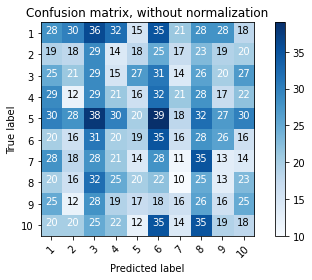

In [15]:

import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf

model = load_model("save_at_11.h5", custom_objects={'SppnetLayer': SppnetLayer})
num_of_test_samples = 2292
Y_pred = model.predict_generator(val_ds, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = tf.concat([y for x, y in val_ds], axis=0)
cm = confusion_matrix(y_true, y_pred)
classes = ['1','2','3','4','5','6','7','8','9','10']
plt.figure()
plot_confusion_matrix(cm, classes=classes,
                      title='Confusion matrix, without normalization')

plt.show()